In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext, TriggerEvent
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers import PortfolioRebalancerTracker
from qubx.core.series import Quote
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.core.utils import recognize_time

from qubx.impl.ccxt_connector import CCXTExchangesConnector
from qubx.impl.ccxt_trading import CCXTTradingConnector
from qubx.utils.runner import get_account_config

def Q(time: str, bid: float, ask: float) -> Quote:
    return Quote(recognize_time(time), bid, ask, 0, 0)

# r = CsvStorageDataReader("../tests/data/csv")
r = MultiQdbConnector('xlydian-data')

from qubx import QubxLogConfig

from qube.portfolio.reports import tearsheet

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        
2024-07-23 10:20:30.789 [ ℹ️ ] NTP offset controller thread is started
2024-07-23 10:20:30.902 [ 🐞 ] Connected to QuestDB at xlydian-data:8812


# Test Strategy

In [2]:
class TestStrategy(IStrategy):
    timeframe: str = "1Min"
    fast_period = 5
    slow_period = 12

    def on_start(self, ctx: StrategyContext):
        logger.info(f" -> Strategy started | {ctx.time()}")

    def on_fit(self, ctx: "StrategyContext", fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")
        data = ctx.get_historical_ohlcs(ctx.instruments[0], '1h', 24)
        logger.info(data)

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        logger.info(f" ||||| {event.time} -> {event} |||||")

        for i in ctx.instruments:
            logger.info(f"\t{i.symbol} : {ctx.broker_provider.get_quote(i.symbol)}")

            if True:
                ohlc = ctx.ohlc(i, self.timeframe)
                fast = ema(ohlc.close, self.fast_period)
                slow = ema(ohlc.close, self.slow_period)
                pos = ctx.positions[i.symbol].quantity
                # cap = ctx.get_capital()
                # n = len(ctx.instruments)
                if pos <= 0:
                    if (fast[0] > slow[0]) and (fast[1] < slow[1]):
                        ctx.trade(i, abs(pos) + i.min_size * 10)

                if pos >= 0:
                    if (fast[0] < slow[0]) and (fast[1] > slow[1]):
                        ctx.trade(i, -pos - i.min_size * 10)

        return None

    def ohlcs(self, timeframe: str) -> Dict[str, pd.DataFrame]:
        return {s.symbol: self.ctx.ohlc(s, timeframe).pd() for s in self.ctx.instruments}

    def on_stop(self, ctx: StrategyContext):
        logger.info(f" -> strategy is stopped")

    def tracker(self, ctx: StrategyContext) -> PortfolioRebalancerTracker:
        return PortfolioRebalancerTracker(ctx, 1000, 0)

# Simulated broker and paper trading

In [4]:
from qubx.backtester.simulator import SimulatedTrading

In [5]:
auth = get_account_config('binance-qbx', './configs/.env')

sim = SimulatedTrading('binance', 10000, 'vip0_usdt', 'USDT')
exch = CCXTExchangesConnector('binance', sim, **auth)

instruments = [lookup.find_symbol('BINANCE', 'BTCUSDT')]
ctx = StrategyContext(
    TestStrategy(), dict(
        timeframe='1Min',
    ), 
    exch, instruments=instruments,  # type: ignore
    md_subscription=dict(type='ohlc', timeframe='1Min', nback=0),
    trigger_spec='1Min -5Sec',
)
S = ctx.strategy

2024-07-22 01:20:57.947 [ ℹ️ ] binance initialized - current time 1970-01-01T00:00:00.000000000
2024-07-22 01:20:57.948 [ ⚠️ ] qubx.core.loggers:__init__:396 - Log writer is not defined - strategy activity will not be saved !
2024-07-22 01:20:57.948 [ ℹ️ ] set strategy parameters:
	set timeframe <- 1Min
2024-07-22 01:20:57.948 [ 🐞 ] Triggering strategy on every 1Min bar after 55S
2024-07-22 01:20:57.948 [ ⚠️ ] qubx.core.loggers:__init__:396 - Log writer is not defined - strategy activity will not be saved !
2024-07-22 01:20:57.948 [ ℹ️ ] set strategy parameters:
	set timeframe <- 1Min
2024-07-22 01:20:57.948 [ 🐞 ] Triggering strategy on every 1Min bar after 55S


In [6]:
ctx.start()

2024-07-22 01:21:02.025 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 0} for 
	['BTCUSDT'] 
2024-07-22 01:21:02.027 [ ℹ️ ] Subscribed on ohlc updates for 1 symbols: 
		['BTCUSDT']
2024-07-22 01:21:02.029 [ ℹ️ ]  -> Strategy started | 1970-01-01T00:00:00.000000000
2024-07-22 01:21:02.030 [ ℹ️ ] (StrategyContext) Start processing market data
2024-07-22 01:21:02.032 [ ℹ️ ] (StrategyContext) strategy is started in thread


2024-07-22 01:21:10.657 [ 🐞 ] [2024-07-21T22:21:10.781562880]: Invoking TestStrategy on_fit('1970-01-01 00:00:00', 'None')
2024-07-22 01:21:10.658 [ ℹ️ ]  -> Fit is called | fit_time: 1970-01-01 00:00:00 / prev: None
2024-07-22 01:21:11.067 [ ℹ️ ] BTCUSDT[1H] | 24 records
  2024-07-21T22:00:00.000000000 {o:68194.000000 | h:68366.660000 | l:68038.000000 | c:68114.000000 | v:30436483.800795}
  2024-07-21T21:00:00.000000000 {o:67723.910000 | h:68298.020000 | l:67564.200000 | c:68193.990000 | v:85407297.413267}
  2024-07-21T20:00:00.000000000 {o:67422.030000 | h:68209.160000 | l:67274.690000 | c:67723.910000 | v:151774422.575169}
   .......... 
  2024-07-21T01:00:00.000000000 {o:67066.020000 | h:67436.220000 | l:67041.070000 | c:67276.330000 | v:24780965.435619}
  2024-07-21T00:00:00.000000000 {o:67139.970000 | h:67322.000000 | l:66962.000000 | c:67066.020000 | v:35409180.504901}
  2024-07-20T23:00:00.000000000 {o:67114.000000 | h:67200.000000 | l:67092.000000 | c:67139.960000 | v:19865751

In [ ]:
exch.get_historical_ohlcs('BTCUSDT', '5Min', 200)

In [8]:
ctx.ohlc(ctx.instruments[0], '1Min')

                        open     high       low     close         volume  \
timestamp                                                                  
2024-07-21 22:21:00  68092.0  68126.2  68091.99  68096.01  410255.488169   

                     bought_volume  
timestamp                           
2024-07-21 22:21:00  240288.718168  

In [6]:
print(exch.trading_service.get_position(instruments[0]))
print(exch.trading_service.get_orders())

??? [BINANCE:BTCUSDT]       0.00000      0.00    +0.0000 | nan        0.00
[]


In [9]:
ctx.trade('BTCUSDT', 0.1)

2024-07-22 01:21:26.058 [ ℹ️ ] (StrategyContext) sending market buy for 0.1 of BTCUSDT ...
2024-07-22 01:21:26.060 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.1 executed at 68078.005
2024-07-22 01:21:26.061 [ ℹ️ ]   ::  traded 0.1 for BTCUSDT @ 68078.005 -> 0.00
2024-07-22 01:21:26.061 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.1 of BTCUSDT -> CLOSED


Order(id='SIM-ORDER-BTCUSDT-100001', type='MARKET', symbol='BTCUSDT', time=numpy.datetime64('2024-07-21T22:21:24.191141120'), quantity=0.1, price=0, side='BUY', status='CLOSED', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_1', cost=0.0)

In [10]:
ctx.trade('BTCUSDT', -0.1)

2024-07-22 01:21:27.671 [ ℹ️ ] (StrategyContext) sending market sell for 0.1 of BTCUSDT ...
2024-07-22 01:21:27.671 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100002 MARKET SELL 0.1 executed at 68077.995
2024-07-22 01:21:27.671 [ ℹ️ ]   ::  traded -0.1 for BTCUSDT @ 68077.995 -> -0.00
2024-07-22 01:21:27.677 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100002 MARKET SELL 0.1 of BTCUSDT -> CLOSED


Order(id='SIM-ORDER-BTCUSDT-100002', type='MARKET', symbol='BTCUSDT', time=numpy.datetime64('2024-07-21T22:21:26.796219648'), quantity=0.1, price=0, side='SELL', status='CLOSED', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_2', cost=0.0)

In [11]:
ctx.trade('BTCUSDT', 0.1, 45000)

2024-07-22 01:21:29.112 [ ℹ️ ] (StrategyContext) sending limit buy for 0.1 of BTCUSDT ...
2024-07-22 01:21:29.117 [ 🐞 ] [OMS] BTCUSDT - registered SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 45000


Order(id='SIM-ORDER-BTCUSDT-100003', type='LIMIT', symbol='BTCUSDT', time=numpy.datetime64('2024-07-21T22:21:28.820779264'), quantity=0.1, price=45000, side='BUY', status='OPEN', time_in_force='gtc', client_id='TestStrategy_BTCUSDT_3', cost=0.0)

In [12]:
ctx.cancel('BTCUSDT')

2024-07-22 01:21:30.410 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 canceled
2024-07-22 01:21:30.410 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 of BTCUSDT -> CANCELED
2024-07-22 01:21:30.410 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100003 LIMIT BUY 0.1 of BTCUSDT -> CANCELED


In [13]:
ctx.stop()
exch.close()

2024-07-22 01:21:33.117 [ ℹ️ ]  -> strategy is stopped
2024-07-22 01:21:33.117 [ ℹ️ ] 	CachedMarketDataHolder.update_by_bar took 0.0000581 secs
2024-07-22 01:21:33.118 [ ℹ️ ] 	StrategyContext._processing_bar took 0.0000847 secs
2024-07-22 01:21:33.118 [ ℹ️ ] 	StrategyContext.handler took 0.0000090 secs
2024-07-22 01:21:33.118 [ ℹ️ ] 	loggers.notify took 0.0000021 secs
2024-07-22 01:21:33.118 [ ℹ️ ] 	StrategyContext._process_incoming_data took 0.0000179 secs
2024-07-22 01:21:33.118 [ ℹ️ ] 	CachedMarketDataHolder.get_ohlcv took 0.0001222 secs
2024-07-22 01:21:33.118 [ ℹ️ ] 	CachedMarketDataHolder.update_by_bars took 0.0004334 secs
2024-07-22 01:21:33.122 [ ℹ️ ] 	StrategyContext.get_historical_ohlcs took 0.4052954 secs
2024-07-22 01:21:33.123 [ ℹ️ ] 	strategy.on_fit took 0.4092440 secs
2024-07-22 01:21:33.123 [ ℹ️ ] 	StrategyContext.trade took 0.0019785 secs
2024-07-22 01:21:33.124 [ ℹ️ ] 	StrategyContext._processing_order took 0.0009156 secs
2024-07-22 01:21:33.125 [ ℹ️ ] 	StrategyContex

# Simulated data provider

In [3]:
from qubx.backtester.simulator import SimulatedTrading, SimulatedExchange
from qubx.core.loggers import CsvFileLogsWriter, InMemoryLogsWriter
from qubx.trackers.rebalancers import PortfolioRebalancerTracker

QubxLogConfig.set_log_level("WARNING")
QubxLogConfig.set_log_level("INFO")
QubxLogConfig.set_log_level("DEBUG")

In [4]:
c1 = {'BINANCE.UM:BTCUSDT': r.read('BINANCE.UM:BTCUSDT', '2024-01-01', '2024-01-02', AsPandasFrame())}

In [5]:
from qubx.data.readers import DataReader, InMemoryDataFrameReader
from qubx.utils.time import infer_series_frequency, handle_start_stop

r1 = InMemoryDataFrameReader(c1)
print(r1.get_names())
print(r.get_names('candles'))


# d1 = r1.read('BTCUSDT', '2024-01-01', '2024-01-01 01:00', RestoreTicksFromOHLC())

['BINANCE.UM:BTCUSDT']
['binance.umfutures.btcusdt.candles_1m', 'binance.umfutures.trxusdt.candles_1m', 'binance.umfutures.nfpusdt.candles_1m', 'binance.umfutures.hbarusdt.candles_1m', 'binance.umfutures.bigtimeusdt.candles_1m', 'binance.umfutures.eosusdt.candles_1m', 'binance.umfutures.jasmyusdt.candles_1m', 'binance.umfutures.cvcusdt.candles_1m', 'binance.umfutures.gmxusdt.candles_1m', 'binance.umfutures.minausdt.candles_1m', 'binance.umfutures.maviausdt.candles_1m', 'binance.umfutures.badgerusdt.candles_1m', 'binance.umfutures.flowusdt.candles_1m', 'binance.umfutures.imxusdt.candles_1m', 'binance.umfutures.stgusdt.candles_1m', 'binance.umfutures.loomusdt.candles_1m', 'binance.umfutures.pixelusdt.candles_1m', 'binance.umfutures.idusdt.candles_1m', 'binance.umfutures.iostusdt.candles_1m', 'binance.umfutures.solusdt.candles_1m', 'binance.umfutures.batusdt.candles_1m', 'binance.umfutures.trxusdt.agg_trade', 'binance.umfutures.arkusdt.candles_1m', 'binance.umfutures.solusdt.agg_trade', '

In [9]:
s = pd.Series([1, 2, 3, 4, 5], name='rrr')

In [31]:
pd.Timestamp('2020-01-01').as_unit('ns').asm8

numpy.datetime64('2020-01-01T00:00:00.000000000')

In [18]:
ll = list(zip(s.index, s.values))
ll.pop(0)


(0, 1)

In [22]:

ll.pe(0)

(4, 5)

In [66]:
from qubx.backtester.simulator import simulate


QubxLogConfig.set_log_level("INFO")
rep = simulate(
    {
        "test0": [pd.Series(
            {
                "2024-01-01 10:00": 1,
                "2024-01-02 12:00": 0,
                "2024-01-03 12:00": -1,
                "2024-01-04 15:00": 0,
            }, name='BTCUSDT'), PortfolioRebalancerTracker(None, 1000, 0)],

        "test1": pd.DataFrame(
            {
                'BTCUSDT': {"2024-01-03 10:00": 1, "2024-01-03 15:00": 0}
            }
        ),
        "test2": TestStrategy(timeframe="1h", fast_period=3, slow_period=24)
    },

    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="5Min", nback=10),
    "1h -2Sec",
    "vip0_usdt", 
    "2024-01-01", "2024-01-10", 
)

2024-07-23 12:17:27.040 [ ℹ️ ] TestStrategy new parameters:
	set timeframe <- 1h
	set fast_period <- 3
	set slow_period <- 24


  0%|          | 0/2 [00:00<?, ?it/s]

2024-07-23 12:17:27.040 [ ℹ️ ] SimulatedData.binance.um initialized
2024-07-23 12:17:27.040 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '5Min', 'nback': 10} for 
	['BTCUSDT'] 


  0%|          | 0/10412 [00:00<?, ?it/s]

2024-07-23 12:17:27.407 [ ℹ️ ] (StrategyContext) sending market buy for 1.0 of BTCUSDT ...
2024-07-23 12:17:27.408 [ ℹ️ ]   ::  traded 1.0 for BTCUSDT @ 42688.850000000006 -> 0.00
2024-07-23 12:17:27.409 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 1.0 of BTCUSDT -> CLOSED
2024-07-23 12:17:27.633 [ ℹ️ ] (StrategyContext) sending market sell for 1.0 of BTCUSDT ...
2024-07-23 12:17:27.633 [ ℹ️ ]   ::  traded -1.0 for BTCUSDT @ 43728.85 -> 1040.05
2024-07-23 12:17:27.633 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100002 MARKET SELL 1.0 of BTCUSDT -> CLOSED
2024-07-23 12:17:28.190 [ ℹ️ ] SimulatedData.binance.um initialized
2024-07-23 12:17:28.190 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '5Min', 'nback': 10} for 
	['BTCUSDT'] 


  0%|          | 0/10412 [00:00<?, ?it/s]

2024-07-23 12:17:28.744 [ ℹ️ ] (StrategyContext) sending market buy for 1.0 of BTCUSDT ...
2024-07-23 12:17:28.744 [ ℹ️ ]   ::  traded 1.0 for BTCUSDT @ 45378.65 -> 0.00
2024-07-23 12:17:28.744 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 1.0 of BTCUSDT -> CLOSED
2024-07-23 12:17:28.744 [ ℹ️ ]   ::  traded 1.0 for BTCUSDT @ 45378.65 -> 0.00
2024-07-23 12:17:28.744 [ ℹ️ ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 1.0 of BTCUSDT -> CLOSED



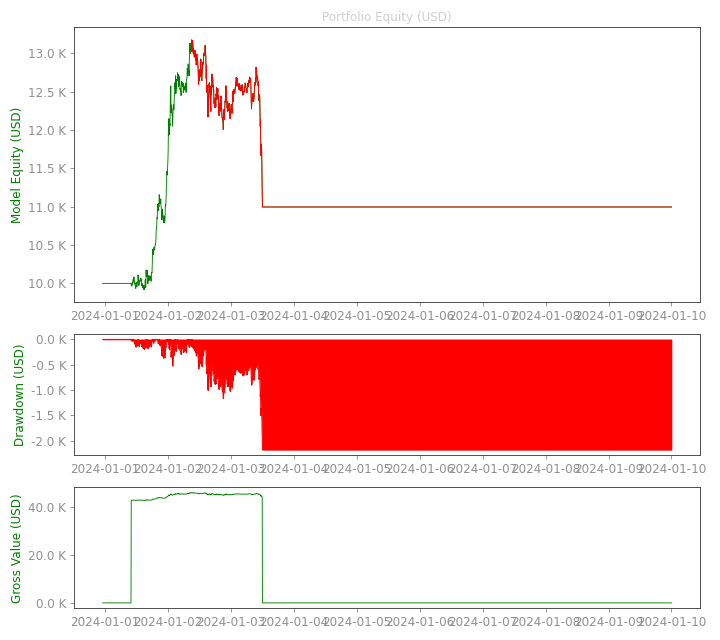

<Figure size 720x640 with 0 Axes>

In [67]:
tearsheet(rep['/test0/0'].get_portfolio(), 10000)

In [21]:
sigs = pd.DataFrame.from_dict({'BTCUSDT': {'2024-01-01 01:00': +1, '2024-01-01 02:00': 0}})
sigs.index = pd.to_datetime(sigs.index)

rep = simulate(
    {
        'test1': [TestStrategy(timeframe='15Min', fast_period=6, slow_period=12)],
        'test2': [TestStrategy(timeframe='15Min', fast_period=7, slow_period=14)],
        # 'test3': sigs,
    }, 
    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="5Min", nback=10),
    "4h -1Sec",
    "vip0_usdt", 
    "2024-01-01", "2024-01-10", 
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10412 [00:00<?, ?it/s]

  0%|          | 0/10412 [00:00<?, ?it/s]


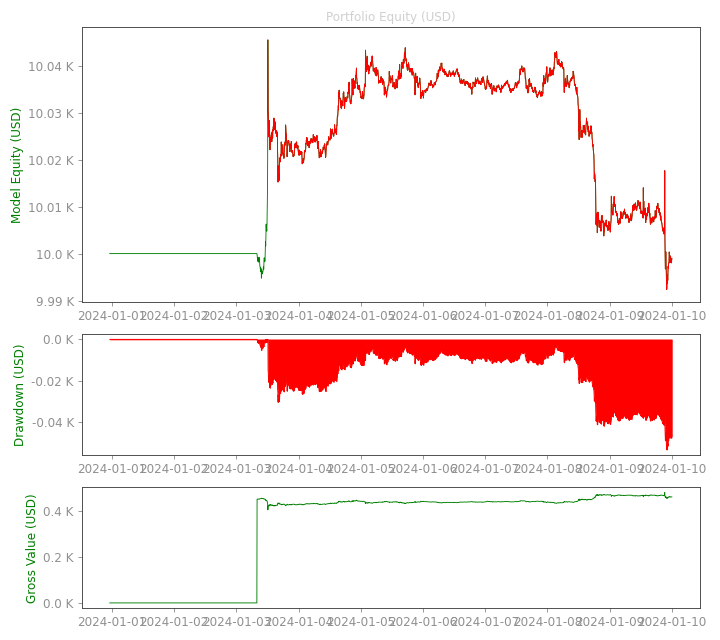

<Figure size 720x640 with 0 Axes>

In [22]:
tearsheet(rep['/test2/0'].get_portfolio(), 10000)

In [75]:
rep

{'/test1/0': <qubx.core.loggers.InMemoryLogsWriter at 0x29683771450>,
 '/test2/0': <qubx.core.loggers.InMemoryLogsWriter at 0x2968218da90>,
 '/test3': <qubx.core.loggers.InMemoryLogsWriter at 0x296851f4f10>}

In [ ]:
# %%time
# d = sdp.run('2024-01-01 00:00', '2024-01-03 00:00')
d = sdp.run('2024-04-01 00:00', '2024-04-15 00:00')
ctx.stop()

In [ ]:
q_pfl = logs_writer.get_portfolio(qube_compatible=True)
tearsheet(q_pfl, 1000, account_transactions=1)

In [216]:
exs.head()

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-02 17:59:59.999,SOLUSDT,sell,-10.0,107.7075,None,None
2024-01-03 06:59:59.999,SOLUSDT,buy,20.0,109.4985,None,None
2024-01-03 07:59:59.999,SOLUSDT,sell,-20.0,107.9585,None,None
2024-01-03 09:59:59.999,SOLUSDT,buy,20.0,109.1885,None,None
2024-01-03 10:59:59.999,SOLUSDT,sell,-20.0,107.5695,None,None


In [ ]:
# pfl = pd.read_csv("logs/Strategy3_Account1_portfolio.csv", index_col='timestamp', parse_dates=True)
pfl = logs_writer.get_portfolio(qube_compatible=False)
exs = logs_writer.get_executions()

<Axes: xlabel='timestamp'>

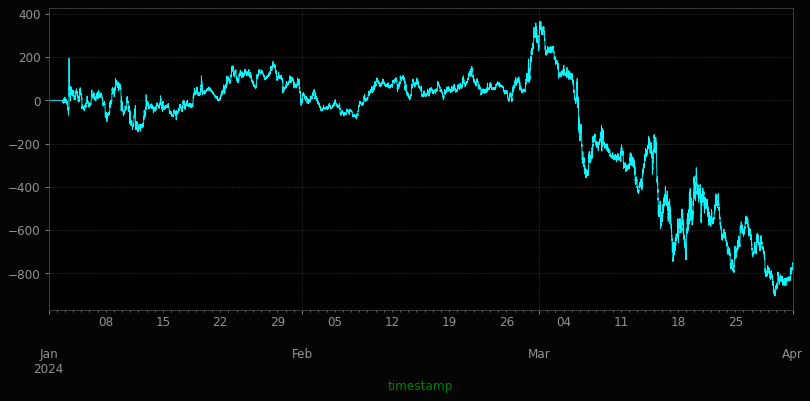

In [217]:
(pfl[pfl['instrument_id'] == 'BTCUSDT'].pnl_quoted + 
 pfl[pfl['instrument_id'] == 'SOLUSDT'].pnl_quoted).plot()
# pfl[pfl['instrument_id'] == 'LINKUSDT'].pnl_quoted.plot()